<a href="https://colab.research.google.com/github/Lavyadev/EXXA/blob/main/General_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Final Dataset Shape: (150, 600, 600, 1)
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 862ms/step - loss: 0.4844
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1053
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0915
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0965
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.1013
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0966
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0967
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0977
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0906
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1007
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Feature Shape: (150, 720000)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP Reduced Feature Shape: (150, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP Reduced Feature Shape: (61, 10)
Filtered Dataset Shape: (61, 600, 600, 1)
Silhouette Score for k=3: 0.6351
Silhouette Score for k=4: 0.6341
Silhouette Score for k=5: 0.5508
Silhouette Score for k=6: 0.4645
Silhouette Score for k=7: 0.4361
Silhouette Score for k=8: 0.4252
Best k found: 3 with Silhouette Score: 0.6351


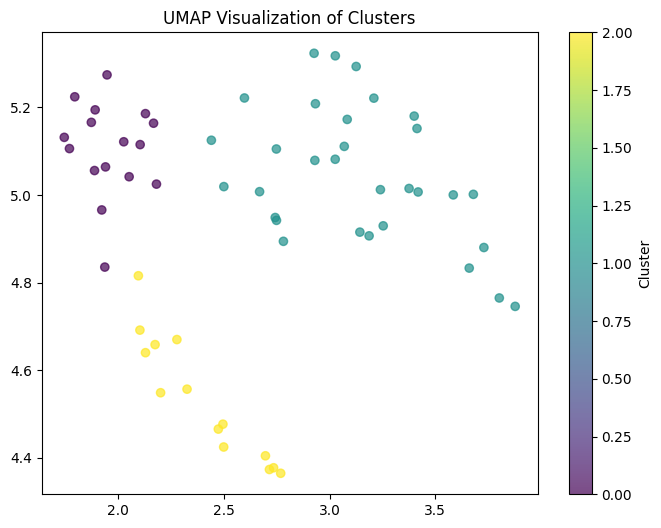

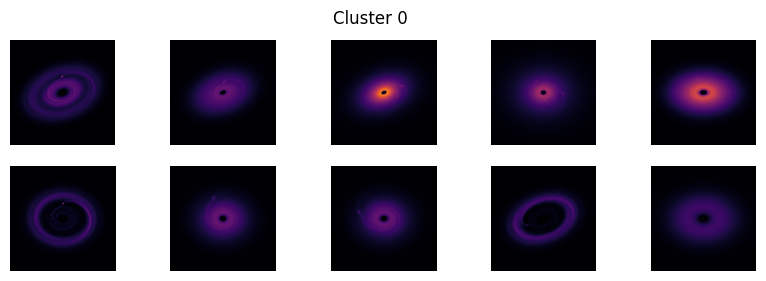

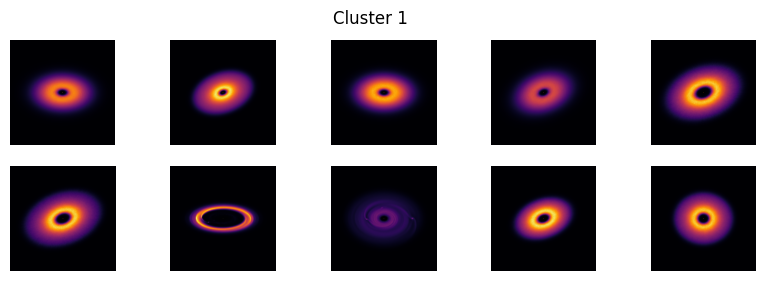

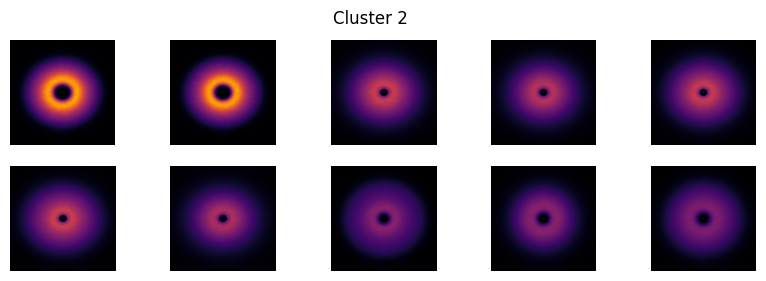

Cluster 0 - Mean Intensity: 0.0412
Cluster 0 - Min Intensity: 0.0000
Cluster 0 - Max Intensity: 1.0000
Cluster 0 - Median Intensity: 0.0020
---------------------------------------------------
Cluster 1 - Mean Intensity: 0.0432
Cluster 1 - Min Intensity: 0.0000
Cluster 1 - Max Intensity: 1.0000
Cluster 1 - Median Intensity: 0.0044
---------------------------------------------------
Cluster 2 - Mean Intensity: 0.0506
Cluster 2 - Min Intensity: 0.0000
Cluster 2 - Max Intensity: 1.0000
Cluster 2 - Median Intensity: 0.0022
---------------------------------------------------


In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Load & Preprocess Data
data_folder = "/content/drive/MyDrive/continuum_data_subset"
image_list = []

for filename in os.listdir(data_folder):
    if filename.endswith(".fits"):
        file_path = os.path.join(data_folder, filename)
        fits_data = fits.open(file_path)
        image_data = np.squeeze(fits_data[0].data)[0]
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
        image_list.append(image_data)
        fits_data.close()

image_array = np.array(image_list)
image_array = np.expand_dims(image_array, axis=-1)

print("Final Dataset Shape:", image_array.shape)

# Build & Train Autoencoder
input_img = Input(shape=(600, 600, 1))


x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)


x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


encoder = Model(input_img, encoded)


autoencoder.fit(image_array, image_array, epochs=10, batch_size=8, shuffle=True)

# Extract Features (from encoder)
features = encoder.predict(image_array)
features = features.reshape(features.shape[0], -1)  # Flatten the encoded features
print("Feature Shape:", features.shape)

# Reduce Features using UMAP
umap_reducer = umap.UMAP(n_components=10, random_state=42)
features_umap = umap_reducer.fit_transform(features)
print("UMAP Reduced Feature Shape:", features_umap.shape)

# Filter Out Low-Intensity Images

brightness_threshold = 0.03


valid_indices = [i for i in range(len(image_array)) if np.mean(image_array[i]) > brightness_threshold]
filtered_images = image_array[valid_indices]
filtered_features = features[valid_indices]


umap_reducer = umap.UMAP(n_components=10, random_state=42)
features_umap = umap_reducer.fit_transform(filtered_features)
print("UMAP Reduced Feature Shape:", features_umap.shape)


print(f"Filtered Dataset Shape: {filtered_images.shape}")

# Best k for K-Means
best_k = None
best_score = -1

for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_umap)
    score = silhouette_score(features_umap, labels)
    print(f"Silhouette Score for k={k}: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best k found: {best_k} with Silhouette Score: {best_score:.4f}")

# Final Clustering with Best k
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = final_kmeans.fit_predict(features_umap)

# Visualize Clusters in UMAP Space
plt.figure(figsize=(8, 6))

plt.scatter(features_umap[:, 0], features_umap[:, 1], c=final_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("UMAP Visualization of Clusters")
plt.show()


# Display Sample Images from Each Cluster
for cluster in range(best_k):
    plt.figure(figsize=(10, 3))
    indices = np.where(final_labels == cluster)[0][:10]

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(filtered_images[idx].squeeze(), cmap='inferno', origin='lower')
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster}")
    plt.show()

# Analyze Cluster Properties
for cluster in range(best_k):
    cluster_indices = np.where(final_labels == cluster)[0]
    mean_intensity = np.mean([np.mean(image_array[i]) for i in cluster_indices])
    min_intensity = np.min([np.min(image_array[i]) for i in cluster_indices])
    max_intensity = np.max([np.max(image_array[i]) for i in cluster_indices])
    median_intensity = np.median([np.median(image_array[i]) for i in cluster_indices])

    print(f"Cluster {cluster} - Mean Intensity: {mean_intensity:.4f}")
    print(f"Cluster {cluster} - Min Intensity: {min_intensity:.4f}")
    print(f"Cluster {cluster} - Max Intensity: {max_intensity:.4f}")
    print(f"Cluster {cluster} - Median Intensity: {median_intensity:.4f}")
    print("---------------------------------------------------")

Final Dataset Shape: (150, 600, 600, 1)
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - loss: 0.5210
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.1140
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.1062
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0989
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0952
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0955
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0983
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.1006
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0929
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0975
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Feature Shape: (150, 720000)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP Reduced Feature Shape: (150, 10)
Filtered Dataset Shape: (61, 600, 600, 1)
Silhouette Score for k=3: 0.4808
Silhouette Score for k=4: 0.4656
Silhouette Score for k=5: 0.5153
Silhouette Score for k=6: 0.5799
Silhouette Score for k=7: 0.5369
Silhouette Score for k=8: 0.5767
Best k found: 6 with Silhouette Score: 0.5799
Unique cluster labels: [0 1 2 3 4 5]


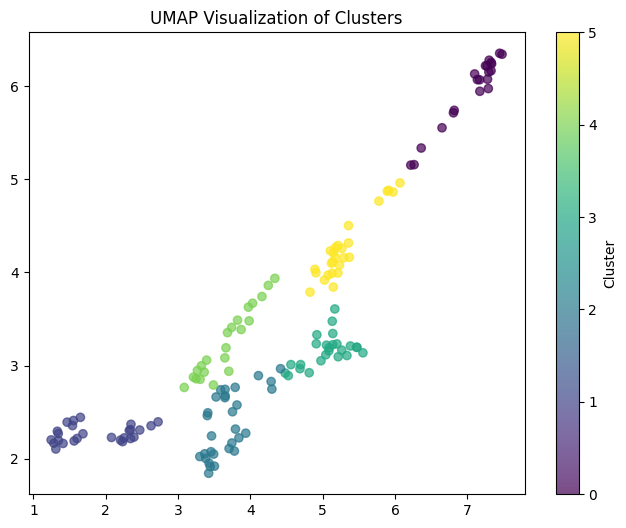

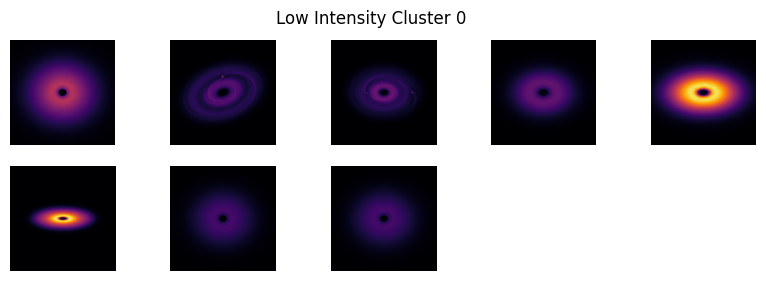

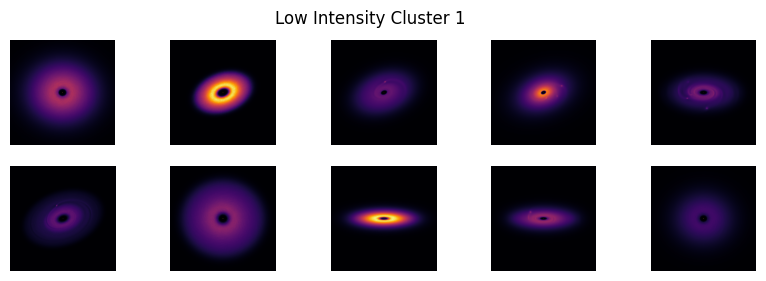

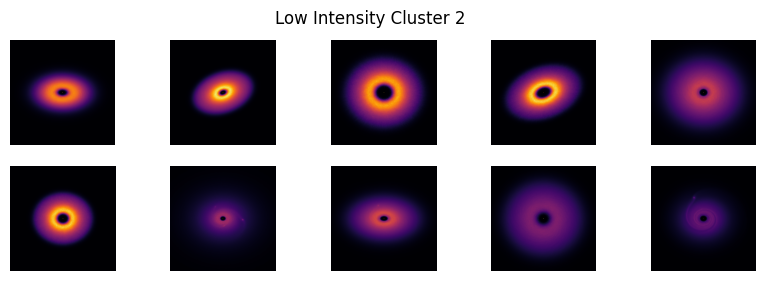

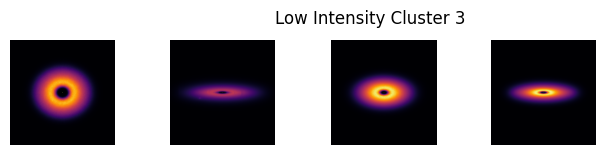

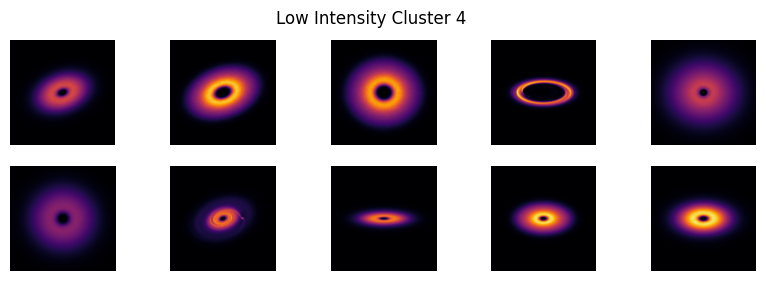

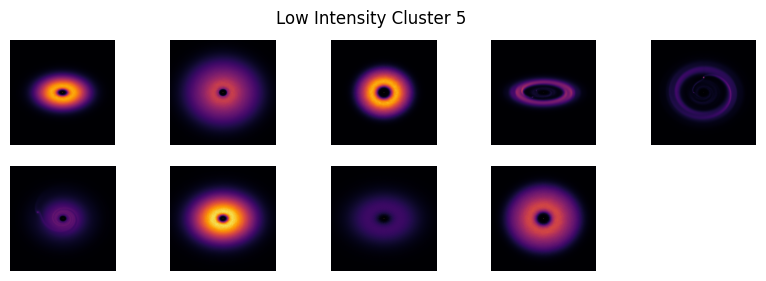

Cluster Low Intensity Cluster 0 - Mean Intensity: 0.0707
Cluster Low Intensity Cluster 0 - Min Intensity: 0.0000
Cluster Low Intensity Cluster 0 - Max Intensity: 1.0000
Cluster Low Intensity Cluster 0 - Median Intensity: 0.0170
---------------------------------------------------
Cluster Low Intensity Cluster 1 - Mean Intensity: 0.0590
Cluster Low Intensity Cluster 1 - Min Intensity: 0.0000
Cluster Low Intensity Cluster 1 - Max Intensity: 1.0000
Cluster Low Intensity Cluster 1 - Median Intensity: 0.0043
---------------------------------------------------
Cluster Low Intensity Cluster 2 - Mean Intensity: 0.0817
Cluster Low Intensity Cluster 2 - Min Intensity: 0.0000
Cluster Low Intensity Cluster 2 - Max Intensity: 1.0000
Cluster Low Intensity Cluster 2 - Median Intensity: 0.0026
---------------------------------------------------
Cluster Low Intensity Cluster 3 - Mean Intensity: 0.0646
Cluster Low Intensity Cluster 3 - Min Intensity: 0.0000
Cluster Low Intensity Cluster 3 - Max Intensity

In [11]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Function to Load & Preprocess Data
def load_data(data_folder):
    image_list = []
    for filename in os.listdir(data_folder):
        if filename.endswith(".fits"):
            file_path = os.path.join(data_folder, filename)
            fits_data = fits.open(file_path)
            image_data = np.squeeze(fits_data[0].data)[0]
            image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
            image_list.append(image_data)
            fits_data.close()

    image_array = np.array(image_list)
    image_array = np.expand_dims(image_array, axis=-1)
    print("Final Dataset Shape:", image_array.shape)
    return image_array

# Function to Build & Train Autoencoder
def build_and_train_autoencoder(image_array):
    input_img = Input(shape=(600, 600, 1))

    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    encoder = Model(input_img, encoded)

    autoencoder.fit(image_array, image_array, epochs=10, batch_size=8, shuffle=True)

    return encoder

# Function to Extract Features
def extract_features(encoder, image_array):
    features = encoder.predict(image_array)
    features = features.reshape(features.shape[0], -1)  # Flatten the encoded features
    print("Feature Shape:", features.shape)
    return features

# Function to Reduce Features using UMAP
def reduce_features(features):
    umap_reducer = umap.UMAP(n_components=10, random_state=42)
    features_umap = umap_reducer.fit_transform(features)
    print("UMAP Reduced Feature Shape:", features_umap.shape)
    return features_umap

# Function to Filter Out Low-Intensity Images
def filter_low_intensity_images(image_array, features):
    brightness_threshold = 0.03
    valid_indices = [i for i in range(len(image_array)) if np.mean(image_array[i]) > brightness_threshold]
    filtered_images = image_array[valid_indices]
    filtered_features = features[valid_indices]

    print(f"Filtered Dataset Shape: {filtered_images.shape}")
    return filtered_images, filtered_features

# Function to Find Best k for K-Means
def find_best_k(features_umap):
    best_k = None
    best_score = -1

    for k in range(3, 9):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features_umap)
        score = silhouette_score(features_umap, labels)
        print(f"Silhouette Score for k={k}: {score:.4f}")

        if score > best_score:
            best_score = score
            best_k = k

    print(f"Best k found: {best_k} with Silhouette Score: {best_score:.4f}")
    return best_k

# Function to Label Clusters (manual or based on properties)
def label_clusters(final_labels, filtered_images, best_k):
    cluster_labels = {}

    # Ensure cluster_labels only refer to valid indices in filtered_images
    for cluster in range(best_k):
        cluster_indices = np.where(final_labels == cluster)[0]
        cluster_intensities = [np.mean(filtered_images[i]) for i in cluster_indices if i < len(filtered_images)]
        if len(cluster_intensities) > 0:
            mean_intensity = np.mean(cluster_intensities)
            # Label based on mean intensity (you can customize this)
            if mean_intensity > 0.5:
                cluster_labels[cluster] = f"High Intensity Cluster {cluster}"
            else:
                cluster_labels[cluster] = f"Low Intensity Cluster {cluster}"
        else:
            cluster_labels[cluster] = f"Empty Cluster {cluster}"

    return cluster_labels


# Function to Visualize Clusters
def visualize_clusters(features_umap, final_labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(features_umap[:, 0], features_umap[:, 1], c=final_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(label="Cluster")
    plt.title("UMAP Visualization of Clusters")
    plt.show()

# Function to Display Sample Images from Each Cluster
def display_sample_images(filtered_images, final_labels, best_k, cluster_labels):
    for cluster in range(best_k):
        plt.figure(figsize=(10, 3))
        # Get the indices of the images in the current cluster
        indices = np.where(final_labels == cluster)[0]

        # Limit the number of images to the size of the current cluster
        num_images_to_display = min(10, len(indices))

        for i, idx in enumerate(indices[:num_images_to_display]):
            # Ensure idx is within the bounds of filtered_images
            if idx < len(filtered_images):
                plt.subplot(2, 5, i + 1)
                plt.imshow(filtered_images[idx].squeeze(), cmap='inferno', origin='lower')
                plt.axis('off')

        plt.suptitle(f"{cluster_labels.get(cluster, 'Unknown Cluster')}")
        plt.show()

# Function to Analyze Cluster Properties
def analyze_cluster_properties(filtered_images, final_labels, best_k, cluster_labels):
    for cluster in range(best_k):
        # Get the indices of the images in the current cluster
        cluster_indices = np.where(final_labels == cluster)[0]

        # Filter out any invalid indices (if any)
        cluster_indices = [i for i in cluster_indices if i < len(filtered_images)]

        if len(cluster_indices) > 0:
            mean_intensity = np.mean([np.mean(filtered_images[i]) for i in cluster_indices])
            min_intensity = np.min([np.min(filtered_images[i]) for i in cluster_indices])
            max_intensity = np.max([np.max(filtered_images[i]) for i in cluster_indices])
            median_intensity = np.median([np.median(filtered_images[i]) for i in cluster_indices])

            print(f"Cluster {cluster_labels.get(cluster, 'Unknown')} - Mean Intensity: {mean_intensity:.4f}")
            print(f"Cluster {cluster_labels.get(cluster, 'Unknown')} - Min Intensity: {min_intensity:.4f}")
            print(f"Cluster {cluster_labels.get(cluster, 'Unknown')} - Max Intensity: {max_intensity:.4f}")
            print(f"Cluster {cluster_labels.get(cluster, 'Unknown')} - Median Intensity: {median_intensity:.4f}")
        else:
            print(f"Cluster {cluster_labels.get(cluster, 'Unknown')} has no valid images.")

        print("---------------------------------------------------")

# Main Function to Automate the Pipeline
def run_pipeline():
    data_folder = "/content/drive/MyDrive/continuum_data_subset"

    # Load Data
    image_array = load_data(data_folder)

    # Build and Train Autoencoder
    encoder = build_and_train_autoencoder(image_array)

    # Extract Features
    features = extract_features(encoder, image_array)

    # Reduce Features with UMAP
    features_umap = reduce_features(features)

    # Filter Low-Intensity Images
    filtered_images, filtered_features = filter_low_intensity_images(image_array, features)

    # Find Best k for Clustering
    best_k = find_best_k(features_umap)

    # Final Clustering
    final_labels = cluster_data(features_umap, best_k)

    # Label Clusters
    cluster_labels = label_clusters(final_labels, filtered_images, best_k)

    # Visualize Clusters
    visualize_clusters(features_umap, final_labels)

    # Display Sample Images
    display_sample_images(filtered_images, final_labels, best_k, cluster_labels)

    # Analyze Cluster Properties
    analyze_cluster_properties(filtered_images, final_labels, best_k, cluster_labels)

# Run the Automated Pipeline
run_pipeline()
